# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs

In [1]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
import inspect
from pathlib import Path
warnings.filterwarnings('ignore')

from dnd_dynamics.analysis import data_loading as dl
from dnd_dynamics.analysis import metrics

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

Anthropic API key loaded
OpenAI API key loaded
Gemini API key loaded
Created plots directory: plots


# Configuration

In [2]:
# === CONFIGURATION ===

# Base campaign names to analyze
CAMPAIGN_BASE_NAMES = [
    '1262-firedeath-must-die-closed-play-by-post-open-ogg',
    '3135-the-head-of-the-serpent',
    '10391-guardians-of-gridori',
    '20049-age-of-death',
    '89221-banhaven-academy-year-1',
    '90630-firecat5s-dragon-of-icespire-peak',
    '7426-serpent-isle-private-campaign',
]

# LLM game filters
LLM_FILTER = {
    'model': ['gpt-4o', 'gemini-1.5-pro', 'claude-3-7-sonnet-latest'],
    'campaign_name': CAMPAIGN_BASE_NAMES,
    'include_player_personalities': [True, False],
    'year': 2025,
    'scratchpad': True,
}

# Category grouping - which metadata fields to group by for aggregation
CATEGORY_FIELDS = ['model', 'include_player_personalities']

# Analysis parameters
MESSAGES_PER_SESSION = 5
FORCE_REFRESH = False

# Output
OUTPUT_DIR = Path('plots')

In [3]:
# === DATA LOADING ===

# Load human campaigns
dfs_human = dl.load_campaigns(
    CAMPAIGN_BASE_NAMES,
    messages_per_session=MESSAGES_PER_SESSION
)

# Load LLM campaigns with filtering
dfs_llm = dl.load_campaigns(
    'llm',
    messages_per_session=MESSAGES_PER_SESSION,
    filter_by=LLM_FILTER
)

# Combine DataFrames
dfs = {**dfs_human, **dfs_llm}

print(f"Loaded {len(dfs_human)} human campaigns, {len(dfs_llm)} LLM campaigns")
print(f"Total: {len(dfs)} campaigns")

Filter matched 42 campaigns
Loading 42 campaigns from /Users/annie/Code/Repositories/dnd-dynamics/data/llm-games/game-logs


Loading campaigns: 100%|██████████| 42/42 [00:02<00:00, 19.78it/s]

Loaded 42 campaigns (10,215 messages)
Loaded 7 human campaigns, 42 LLM campaigns
Total: 49 campaigns


# Calculate game log analyses

In [4]:
# === METRICS CALCULATION ===

all_metrics = metrics.analyze_all(dfs, force_refresh=FORCE_REFRESH)

basic_metrics = all_metrics['basic']
semantic_metrics = all_metrics['semantic']
jaccard_metrics = all_metrics['jaccard']
dsi_metrics = all_metrics['dsi']

📁 Loaded 49 cached basic metrics results
📁 Loaded 49 cached jaccard results
📁 Loaded 49 cached semantic results
📁 Loaded 49 cached DSI results


# Helper Functions

In [5]:
def plot_histogram(data,
                   colors=None,
                   edgecolor='none',
                   alpha=0.5,
                   colormap='viridis',
                   xlabel=None,
                   bins=None,
                   log_bins=False,
                   log_y=False,
                   figsize=(4, 4),
                   ylabel="Counts",
                   labels=None):
    """
    Plot histogram(s) with colors evenly spaced across a colormap.
    
    Parameters:
    data: Single array/list OR list of arrays/lists to plot as histograms
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    """
    plt.figure(figsize=figsize)

    # Auto-detect if data is a single array or list of arrays
    try:
        if isinstance(data[0], (list, np.ndarray)):
            data_list = data  # Already a list of arrays
        else:
            data_list = [data]  # Single array, wrap it in a list
    except:
        data_list = [data]

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    n_plots = len(clean_data_list)

    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_plots == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_plots - 1)) for i in range(n_plots)]

    # Calculate common bins across all datasets (now NaN-free)
    all_data = np.concatenate(clean_data_list)

    if len(all_data) == 0:
        raise ValueError("All data contains only NaN values")

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50  # Default number of log bins

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50  # Default number of bins

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Plot all histograms with the same bins (NaN-free data)
    for i, dataset in enumerate(clean_data_list):
        if labels is not None:
            label = labels[i]
        else:
            label = None
        plt.hist(dataset,
                 bins=common_bins,
                 color=colors[i],
                 edgecolor=edgecolor,
                 alpha=alpha,
                 label=label)

    # Set axis scales
    if log_bins:
        plt.xscale('log')

    if log_y:
        plt.yscale('log')

    sns.despine()
    plt.ylabel(ylabel)

    if xlabel is not None:
        plt.xlabel(xlabel, clip_on=False)
    # Style axes
    ax = plt.gca()
    ax.tick_params(colors='#4a4a4a', width=0.5)
    ax.spines['left'].set_color('#4a4a4a')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('#4a4a4a')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.label.set_color('#4a4a4a')
    ax.yaxis.label.set_color('#4a4a4a')

In [6]:
# === CATEGORIZATION FUNCTIONS ===

def categorize_campaigns(campaign_names, category_fields):
    """
    Categorize campaigns based on metadata fields.

    Args:
        campaign_names: List of campaign names (keys from dfs)
        category_fields: List of metadata fields to use for grouping
                        e.g., ['model', 'include_player_personalities']

    Returns:
        Dict mapping category_name -> list of campaign names
        e.g., {'human': [...], 'model:gpt-4o, include_player_personalities:True': [...]}
    """
    # Load metadata index (relative to tutorials/ directory)
    metadata_index_path = Path('../data/llm-games/metadata_index.json')
    with open(metadata_index_path) as f:
        metadata_index = json.load(f)

    categories = {'human': []}

    for name in campaign_names:
        # Check if it's in metadata_index (LLM game)
        if name in metadata_index:
            metadata = metadata_index[name]

            # Build category key as "field1:value1, field2:value2"
            parts = []
            for field in category_fields:
                value = metadata.get(field)
                if value is not None:
                    parts.append(f"{field}:{value}")

            category_key = ', '.join(parts) if parts else 'llm_other'

            if category_key not in categories:
                categories[category_key] = []
            categories[category_key].append(name)
        else:
            # Human campaign (not in LLM metadata index)
            categories['human'].append(name)

    return categories


def aggregate_by_category(metric_data, campaign_names, categories, category_order=None):
    """
    Aggregate metric data by category.

    Args:
        metric_data: List of metric arrays, one per campaign (in same order as campaign_names)
        campaign_names: List of campaign names corresponding to metric_data
        categories: Dict from categorize_campaigns()
        category_order: Optional list specifying order of categories in output

    Returns:
        Tuple of (aggregated_data, category_order) where aggregated_data is a list of 
        concatenated arrays, one per category
    """
    # Build name -> index mapping
    name_to_idx = {name: i for i, name in enumerate(campaign_names)}

    # Default order: human first, then sorted
    if category_order is None:
        category_order = ['human'] + sorted(k for k in categories.keys() if k != 'human')

    result = []
    for cat in category_order:
        cat_names = categories.get(cat, [])
        if cat_names:
            cat_data = [metric_data[name_to_idx[n]] for n in cat_names if n in name_to_idx]
            result.append(np.concatenate(cat_data) if cat_data else np.array([]))
        else:
            result.append(np.array([]))

    return result, category_order

In [7]:
# === DATA PREPARATION ===

# Get ordered campaign names
campaign_names = list(dfs.keys())

# Categorize campaigns using metadata
categories = categorize_campaigns(campaign_names, CATEGORY_FIELDS)

# Print category summary
print("Campaign categories:")
for cat, names in categories.items():
    print(f"  {cat}: {len(names)} campaigns")

# Build metric lists (in same order as campaign_names)
time_intervals_data = []
post_len_data = []
sbert_post_distances = []
sbert_session_creativity = []
cohesion_session_scores = []
dsi_scene_scores = []

for name in campaign_names:
    # Time intervals
    time_intervals_data.append(
        basic_metrics[name]['time_intervals_overall']['overall']['intervals_data']
    )
    
    # Post lengths
    post_len_data.append(
        basic_metrics[name]['post_lengths_overall']['overall']['word_counts_data']
    )
    
    # Semantic distances
    sbert_post_distances.append(
        np.array(semantic_metrics[name]['semantic_distances'])
    )
    
    # Session novelty
    sbert_session_creativity.append(
        np.array(semantic_metrics[name]['session_novelty'][['mean_distance']])
    )
    
    # Jaccard cohesion scores
    if jaccard_metrics[name] is not None:
        cohesion_session_scores.append(
            np.array(jaccard_metrics[name]['session_cohesion_scores'])
        )
    else:
        cohesion_session_scores.append(np.array([np.nan]))
    
    # DSI scene scores
    dsi_scene_scores.append(
        np.array(dsi_metrics[name]['scene_dsi_scores'])
    )

Campaign categories:
  human: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:False: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:True: 7 campaigns
  model:gpt-4o, include_player_personalities:False: 7 campaigns
  model:gpt-4o, include_player_personalities:True: 7 campaigns


In [8]:
def plot_comparison_histograms(data,
                               colors=None,
                               edgecolor='none',
                               alpha=0.5,
                               colormap='viridis',
                               xlabel=None,
                               bins=None,
                               log_bins=False,
                               log_y=False,
                               labels=None,
                               figsize=None,
                               ylabel="Counts"):
    """
    Plot comparison histograms with the first dataset appearing in every subplot,
    and each subsequent dataset compared against it in separate vertical subplots.
    
    Parameters:
    data: List of arrays/lists (must have at least 2 datasets)
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    labels (list): Labels for each dataset (default: None)
    figsize (tuple): Figure size (width, height). If None, auto-calculated
    """

    # Validate input
    if not isinstance(data, list) or len(data) < 2:
        raise ValueError("data must be a list with at least 2 datasets")

    # Auto-detect if data contains arrays or single values
    data_list = []
    for dataset in data:
        try:
            if isinstance(dataset[0], (list, np.ndarray)):
                data_list.append(dataset)
            else:
                data_list.append(dataset)
        except:
            data_list.append(dataset)

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    if any(len(dataset) == 0 for dataset in clean_data_list):
        raise ValueError("One or more datasets contain only NaN values")

    n_datasets = len(clean_data_list)
    n_subplots = n_datasets - 1  # Number of comparison subplots

    # Set up figure size
    if figsize is None:
        figsize = (8, 3 * n_subplots)  # 3 inches height per subplot

    fig, axes = plt.subplots(n_subplots, 1, figsize=figsize, sharex=True)
    plt.subplots_adjust(hspace=0)
    # Handle case where there's only one comparison (single axis)
    if n_subplots == 1:
        axes = [axes]

    # Set up colors
    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_datasets == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_datasets - 1)) for i in range(n_datasets)]

    # Calculate common bins across all datasets
    all_data = np.concatenate(clean_data_list)

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Reference dataset (first one)
    reference_data = clean_data_list[0]
    reference_color = colors[0]
    reference_label = labels[0] if labels is not None else "Reference"

    # Plot each comparison
    for i in range(n_subplots):
        ax = axes[i]

        # Current comparison dataset (i+1 because we skip the reference)
        comparison_data = clean_data_list[i + 1]
        comparison_color = colors[i + 1]
        comparison_label = labels[
            i + 1] if labels is not None else f"Dataset {i + 1}"

        # Plot reference histogram (same in every subplot)
        ax.hist(reference_data,
                bins=common_bins,
                color=reference_color,
                edgecolor=edgecolor,
                alpha=alpha,
                label=reference_label)

        # Plot comparison histogram
        ax.hist(comparison_data,
                bins=common_bins,
                color=comparison_color,
                edgecolor=edgecolor,
                alpha=alpha,
                label=comparison_label)

        # Set axis scales
        if log_bins:
            ax.set_xscale('log')

        if log_y:
            ax.set_yscale('log')

        # Style the subplot
        sns.despine(ax=ax)

        # Only add ylabel to the middle subplot
        if i == n_subplots // 2:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")

        # Don't add legend here - can be added outside function if needed

        # Style axes
        ax.tick_params(colors='#4a4a4a', width=0.5, length=2)
        ax.spines['left'].set_color('#4a4a4a')
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_color('#4a4a4a')
        ax.spines['bottom'].set_linewidth(0.5)
        ax.xaxis.label.set_color('#4a4a4a')
        ax.yaxis.label.set_color('#4a4a4a')
        ax.set_facecolor("none")
        ax.minorticks_off()
    # Only add xlabel to the bottom subplot
    if xlabel is not None:
        axes[-1].set_xlabel(xlabel)

    # Adjust layout to prevent overlap
    #plt.tight_layout()

    # Set same y-limits for all subplots
    # Find the maximum y-limit across all subplots
    max_ylim = 0
    for ax in axes:
        current_ylim = ax.get_ylim()[1]
        max_ylim = max(max_ylim, current_ylim)
    # Apply the same y-limit to all subplots
    for ax in axes:
        ax.set_ylim(0, max_ylim)
        ax.set_yticks([0, np.round(max_ylim*.7/10)*10])
    return fig, axes

In [9]:
# === MEAN METRICS PER CAMPAIGN ===

mean_sbert_session_creat = np.zeros(len(sbert_session_creativity))
mean_cohesion_session = np.zeros(len(cohesion_session_scores))
mean_sbert_post_distances = np.zeros(len(sbert_post_distances))
mean_dsi_scores = np.zeros(len(dsi_scene_scores))

for i in range(len(campaign_names)):
    mean_sbert_session_creat[i] = np.mean(sbert_session_creativity[i])
    mean_cohesion_session[i] = np.mean(cohesion_session_scores[i])
    mean_sbert_post_distances[i] = np.nanmean(sbert_post_distances[i])
    mean_dsi_scores[i] = np.nanmean(dsi_scene_scores[i])

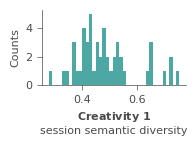

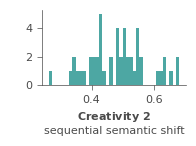

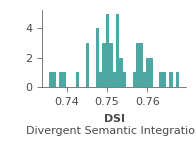

In [10]:
# Single histogram of mean values per campaign
plt.rcParams.update({'font.size': 8})

plot_histogram(mean_sbert_session_creat,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 1}$' + '\nsession semantic diversity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'creativity1.pdf', transparent=True)

plot_histogram(mean_sbert_post_distances,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 2}$' + '\nsequential semantic shift')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'creativity2.pdf', transparent=True)

plot_histogram(mean_dsi_scores,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{DSI}$' + '\nDivergent Semantic Integration')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dsi.pdf', transparent=True)

In [11]:
# === COMBINED HISTOGRAMS (All Data) ===

time_intervals_all = np.concatenate(time_intervals_data)
post_lengths_all = np.concatenate(post_len_data)

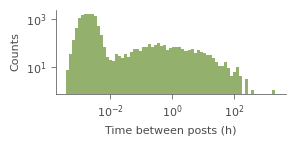

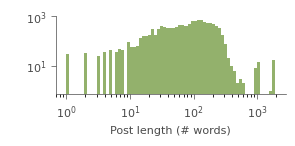

In [12]:
plot_histogram(time_intervals_all,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'time_intervals.pdf', transparent=True)

plot_histogram(post_lengths_all,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)')
plt.tight_layout()

Aggregated category sizes:
  human: 1821 data points
  model:gemini-1.5-pro, include_player_personalities:False: 1811 data points
  model:gemini-1.5-pro, include_player_personalities:True: 1811 data points
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 1449 data points
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 1518 data points
  model:gpt-4o, include_player_personalities:False: 1811 data points
  model:gpt-4o, include_player_personalities:True: 1811 data points


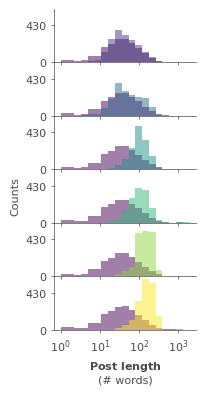

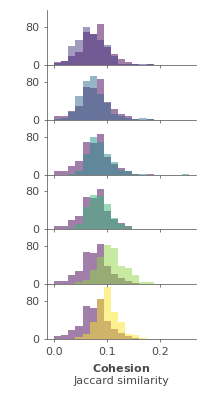

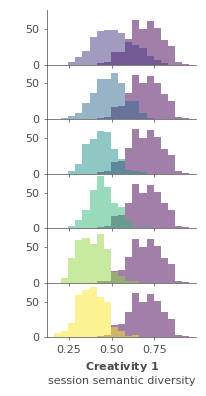

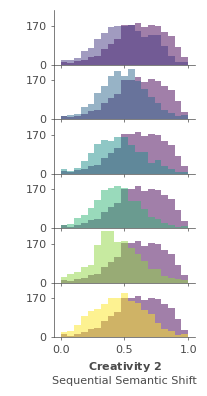

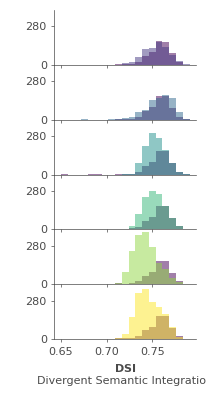

In [13]:
# === VISUALIZATION (Aggregated by Category) ===

# Define category display order (must match format from categorize_campaigns)
CATEGORY_ORDER = [
    'human',
    'model:gemini-1.5-pro, include_player_personalities:False',
    'model:gemini-1.5-pro, include_player_personalities:True',
    'model:claude-3-7-sonnet-latest, include_player_personalities:False',
    'model:claude-3-7-sonnet-latest, include_player_personalities:True',
    'model:gpt-4o, include_player_personalities:False',
    'model:gpt-4o, include_player_personalities:True',
]

# Aggregate by category
post_len_agg, _ = aggregate_by_category(post_len_data, campaign_names, categories, CATEGORY_ORDER)
cohesion_agg, _ = aggregate_by_category(cohesion_session_scores, campaign_names, categories, CATEGORY_ORDER)
creativity_1_agg, _ = aggregate_by_category(sbert_session_creativity, campaign_names, categories, CATEGORY_ORDER)
creativity_2_agg, _ = aggregate_by_category(sbert_post_distances, campaign_names, categories, CATEGORY_ORDER)
dsi_agg, _ = aggregate_by_category(dsi_scene_scores, campaign_names, categories, CATEGORY_ORDER)

# Check category sizes
print("Aggregated category sizes:")
for i, cat in enumerate(CATEGORY_ORDER):
    print(f"  {cat}: {len(post_len_agg[i])} data points")

plt.rcParams.update({'font.size': 8})

# Post length comparison
plot_comparison_histograms(
    post_len_agg,
    bins=20,
    log_bins=True,
    log_y=False,
    xlabel=r'$\mathbf{Post\ length}$' + '\n(# words)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_len.pdf', transparent=True)

# Cohesion comparison
plot_comparison_histograms(
    cohesion_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Cohesion}$' + '\nJaccard similarity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_cohesion.pdf', transparent=True)

# Creativity 1 comparison
plot_comparison_histograms(
    creativity_1_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 1}$' + '\nsession semantic diversity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_creativity.pdf', transparent=True)

# Creativity 2 comparison
plot_comparison_histograms(
    creativity_2_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 2}$' + '\nSequential Semantic Shift',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)

# DSI comparison
plot_comparison_histograms(
    dsi_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{DSI}$' + '\nDivergent Semantic Integration',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_dsi.pdf', transparent=True)

# Full Human Dataset Analysis

Analysis of all ~985 human campaigns from the dataset to establish comprehensive baseline patterns.

In [14]:
# === LOAD ALL HUMAN CAMPAIGNS ===

dfs_all_human = dl.load_campaigns(
    'human',
    messages_per_session=MESSAGES_PER_SESSION
)

print(f"Loaded {len(dfs_all_human)} human campaigns")

Loading 985 campaigns from /Users/annie/Code/Repositories/dnd-dynamics/data/corrected-human-games


Loading campaigns: 100%|██████████| 985/985 [02:50<00:00,  5.77it/s]

Loaded 984 campaigns (949,460 messages)
Loaded 984 human campaigns


In [15]:
# === CALCULATE METRICS FOR ALL HUMAN CAMPAIGNS ===

all_metrics_all_human = metrics.analyze_all(dfs_all_human, force_refresh=FORCE_REFRESH)

basic_metrics_all_human = all_metrics_all_human['basic']
semantic_metrics_all_human = all_metrics_all_human['semantic']
jaccard_metrics_all_human = all_metrics_all_human['jaccard']
dsi_metrics_all_human = all_metrics_all_human['dsi']

📁 Loaded 984 cached basic metrics results
📁 Loaded 984 cached jaccard results
📁 Loaded 984 cached semantic results
📁 Loaded 984 cached DSI results


In [16]:
# === PREPARE DATA ===

# Aggregate all data
time_intervals_all_human = []
post_lengths_all_human = []
creativity_1_all_human = []
creativity_2_all_human = []
cohesion_all_human = []
dsi_all_human = []

for name in dfs_all_human.keys():
    time_intervals_all_human.append(
        basic_metrics_all_human[name]['time_intervals_overall']['overall']['intervals_data']
    )
    post_lengths_all_human.append(
        basic_metrics_all_human[name]['post_lengths_overall']['overall']['word_counts_data']
    )
    creativity_1_all_human.append(
        np.array(semantic_metrics_all_human[name]['session_novelty']['mean_distance'])
    )
    creativity_2_all_human.append(
        np.array(semantic_metrics_all_human[name]['semantic_distances'])
    )
    if jaccard_metrics_all_human[name] is not None:
        cohesion_all_human.append(
            np.array(jaccard_metrics_all_human[name]['session_cohesion_scores'])
        )
    dsi_all_human.append(
        np.array(dsi_metrics_all_human[name]['scene_dsi_scores'])
    )

# Concatenate
time_intervals_all_human = np.concatenate(time_intervals_all_human)
post_lengths_all_human = np.concatenate(post_lengths_all_human)
creativity_1_all_human = np.concatenate(creativity_1_all_human)
creativity_2_all_human = np.concatenate(creativity_2_all_human)
cohesion_all_human = np.concatenate(cohesion_all_human)
dsi_all_human = np.concatenate(dsi_all_human)

print(f"Data points - Time intervals: {len(time_intervals_all_human)}, "
      f"Post lengths: {len(post_lengths_all_human)}, "
      f"Creativity 1: {len(creativity_1_all_human)}, "
      f"Creativity 2: {len(creativity_2_all_human)}, "
      f"Cohesion: {len(cohesion_all_human)}, "
      f"DSI: {len(dsi_all_human)}")

Data points - Time intervals: 948476, Post lengths: 949460, Creativity 1: 190058, Creativity 2: 949460, Cohesion: 189633, DSI: 381134


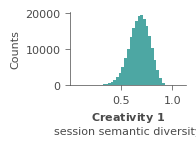

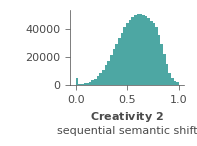

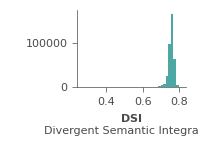

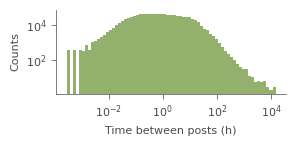

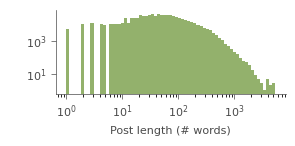

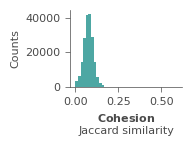

In [17]:
# === FULL HUMAN DATASET PLOTS ===

plt.rcParams.update({'font.size': 8})

# Creativity 1
plot_histogram(creativity_1_all_human,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 1}$' + '\nsession semantic diversity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_creativity1.png', transparent=True)

# Creativity 2
plot_histogram(creativity_2_all_human,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 2}$' + '\nsequential semantic shift')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_creativity2.png', transparent=True)

# DSI
plot_histogram(dsi_all_human,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{DSI}$' + '\nDivergent Semantic Integration')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_dsi.png', transparent=True)

# Time intervals
plot_histogram(time_intervals_all_human,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)')
plt.tight_layout()
#plt.savefig(OUTPUT_DIR / 'all_human_time_intervals.pdf', transparent=True)

# Post lengths
plot_histogram(post_lengths_all_human,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_post_lengths.png', transparent=True)

# Cohesion
plot_histogram(cohesion_all_human,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Cohesion}$' + '\nJaccard similarity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_cohesion.png', transparent=True)

# Metric Correlation Analysis

Compute correlations between campaign-level metric means to understand which metrics capture unique vs. redundant information.

Correlation matrix computed from 984 campaigns


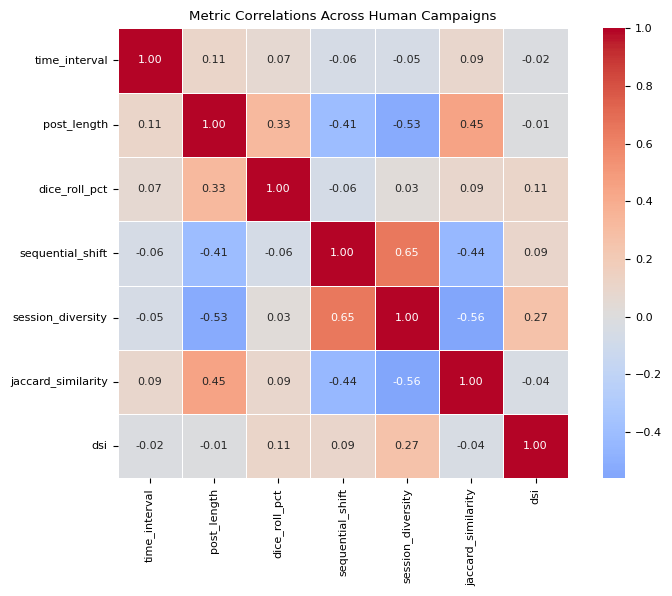

In [18]:
# === METRIC CORRELATION ANALYSIS ===

# Build DataFrame with campaign-level means
correlation_data = []

for name in dfs_all_human.keys():
    row = {
        'campaign': name,
        'time_interval': basic_metrics_all_human[name]['time_intervals_overall']['overall']['mean_hours'],
        'post_length': basic_metrics_all_human[name]['post_lengths_overall']['overall']['mean_words'],
        'dice_roll_pct': basic_metrics_all_human[name]['dice_roll_frequency']['roll_percentage'],
        'sequential_shift': np.nanmean(semantic_metrics_all_human[name]['semantic_distances']),
        'session_diversity': semantic_metrics_all_human[name]['session_novelty']['mean_distance'].mean(),
        'dsi': dsi_metrics_all_human[name]['time_averaged_dsi'],
    }
    # Handle potential None for jaccard
    if jaccard_metrics_all_human[name] is not None:
        row['jaccard_similarity'] = np.mean(jaccard_metrics_all_human[name]['session_cohesion_scores'])
    else:
        row['jaccard_similarity'] = np.nan

    correlation_data.append(row)

corr_df = pd.DataFrame(correlation_data)

# Compute correlation matrix (exclude campaign name column)
metric_cols = ['time_interval', 'post_length', 'dice_roll_pct',
               'sequential_shift', 'session_diversity', 'jaccard_similarity', 'dsi']
corr_matrix = corr_df[metric_cols].corr()

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Metric Correlations Across Human Campaigns')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metric_correlations.png', dpi=300)

print(f"Correlation matrix computed from {len(corr_df)} campaigns")